## Librerias

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv,GATv2Conv
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.optim import Adam
import nltk
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.utils import from_networkx
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges, negative_sampling, from_networkx
from torch_geometric.utils import degree
from random import randint

## Base de datos

In [2]:
df = pd.read_csv('C:/Users/adria/OneDrive/Desktop/Topicos/Reviews/Reviews.csv')
print(df.shape)
df = df.head(40000)
print(df.shape)
df.head()

(568454, 10)
(40000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## EDA

In [3]:
# Normalizar las calificaciones
df['weight'] = df['Score'] / df['Score'].max()

# Mapeo de usuarios y productos
user_ids = df['UserId'].unique()
product_ids = df['ProductId'].unique()
user_id_map = {uid: idx for idx, uid in enumerate(user_ids)}
product_id_map = {pid: idx + len(user_ids) for idx, pid in enumerate(product_ids)}
node_mapping = {**user_id_map, **product_id_map}

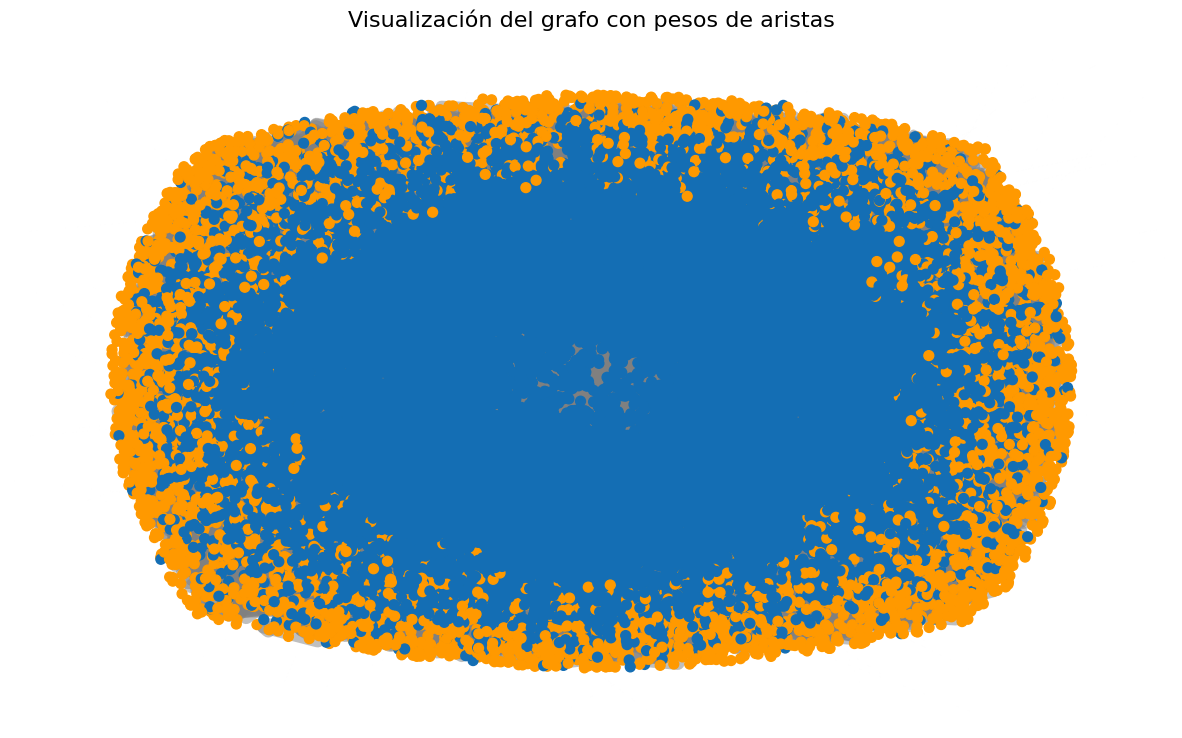

In [4]:
# Crear el grafo
G = nx.DiGraph()
for _, row in df.iterrows():
    user_node = node_mapping[row['UserId']]
    product_node = node_mapping[row['ProductId']]
    G.add_node(user_node, type='user')
    G.add_node(product_node, type='product')
    G.add_edge(user_node, product_node, weight=row['weight'])  # Añadir peso de la arista

data = from_networkx(G)

num_nodes = len(node_mapping)
num_node_features = 745 
data.x = torch.randn((num_nodes, num_node_features), dtype=torch.float)
data.edge_weight = torch.tensor([d['weight'] for u, v, d in G.edges(data=True)], dtype=torch.float)

# Visualización del grafo
colors = ['#FF9900' if G.nodes[node]['type'] == 'product' else '#146EB4' for node in G.nodes]
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
G = nx.convert_node_labels_to_integers(G)
pos = nx.spring_layout(G, iterations=15, seed=1306)
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=50)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[w * 10 for w in weights], alpha=0.5, edge_color="gray")
plt.title("Visualización del grafo con pesos de aristas", fontsize=16)
plt.show()

[(14582, 0.05408408106372136), (17103, 0.05087643864579009), (23022, 0.04835542798305454), (7391, 0.039455490576917066), (21192, 0.03679185704244216), (23639, 0.03607145838491938), (30084, 0.03607145838491938), (21894, 0.033100642009914506)]


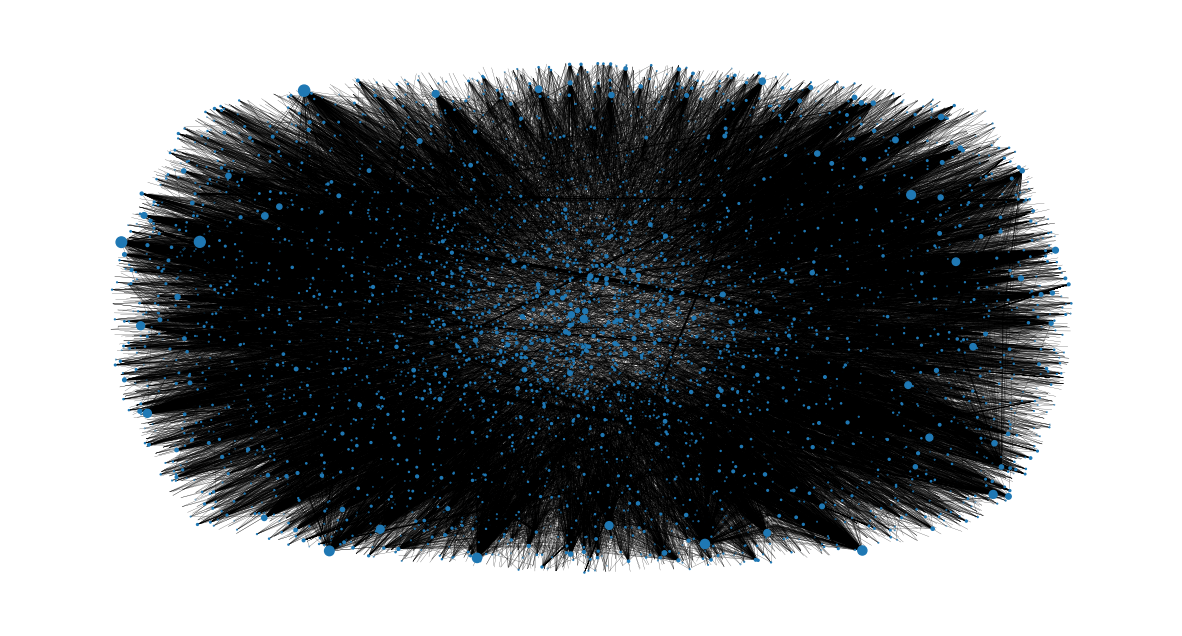

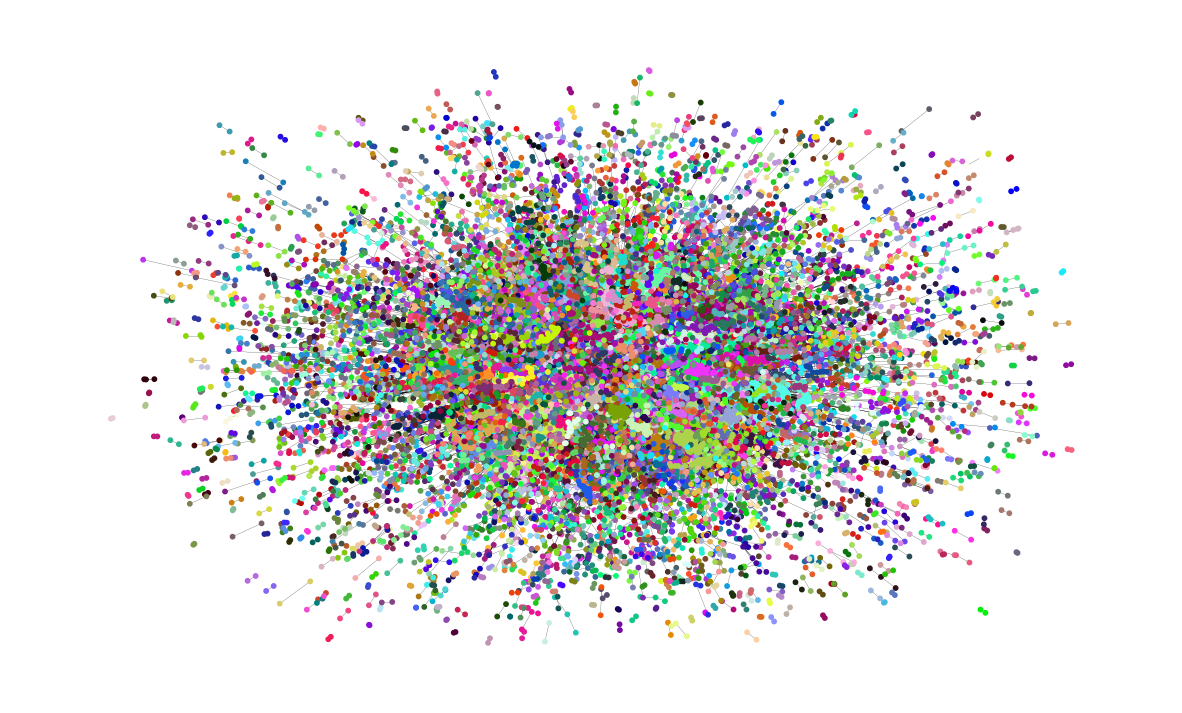

In [38]:
# Análisis de comunidades
betweenness_centrality = nx.centrality.betweenness_centrality(G)
top_centrality_nodes = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)[:8]
print(top_centrality_nodes)

node_size = [v * 1200 for v in betweenness_centrality.values()]

plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")
plt.show()

G = nx.convert_node_labels_to_integers(G)

assert all(0 <= node < G.number_of_nodes() for node in G.nodes()), "Nodo fuera del rango esperado"

colors = [""] * G.number_of_nodes() 
counter = 0
for com in nx.community.label_propagation_communities(G):
    color = "#%06X" % randint(0, 0xFFFFFF) 
    counter += 1
    for node in list(com):  
        colors[node] = color

# Visualizar el grafo con colores para las comunidades
pos = nx.spring_layout(G, iterations=15, seed=1721)
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors)
plt.show()


In [5]:
# Calcular la centralidad de grado
degree_centrality = nx.degree_centrality(G)

# Calcular la centralidad de intermediación
betweenness_centrality = nx.betweenness_centrality(G)

print("Nodos más importantes por centralidad de grado:")
print(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])
print("\nNodos más importantes por centralidad de intermediación:")
print(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

Nodos más importantes por centralidad de grado:
[(21192, 0.016048699501936912), (21894, 0.014625662107676497), (23639, 0.014520251930323873), (30084, 0.014520251930323873), (28635, 0.012780984004005588)]

Nodos más importantes por centralidad de intermediación:
[(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0)]


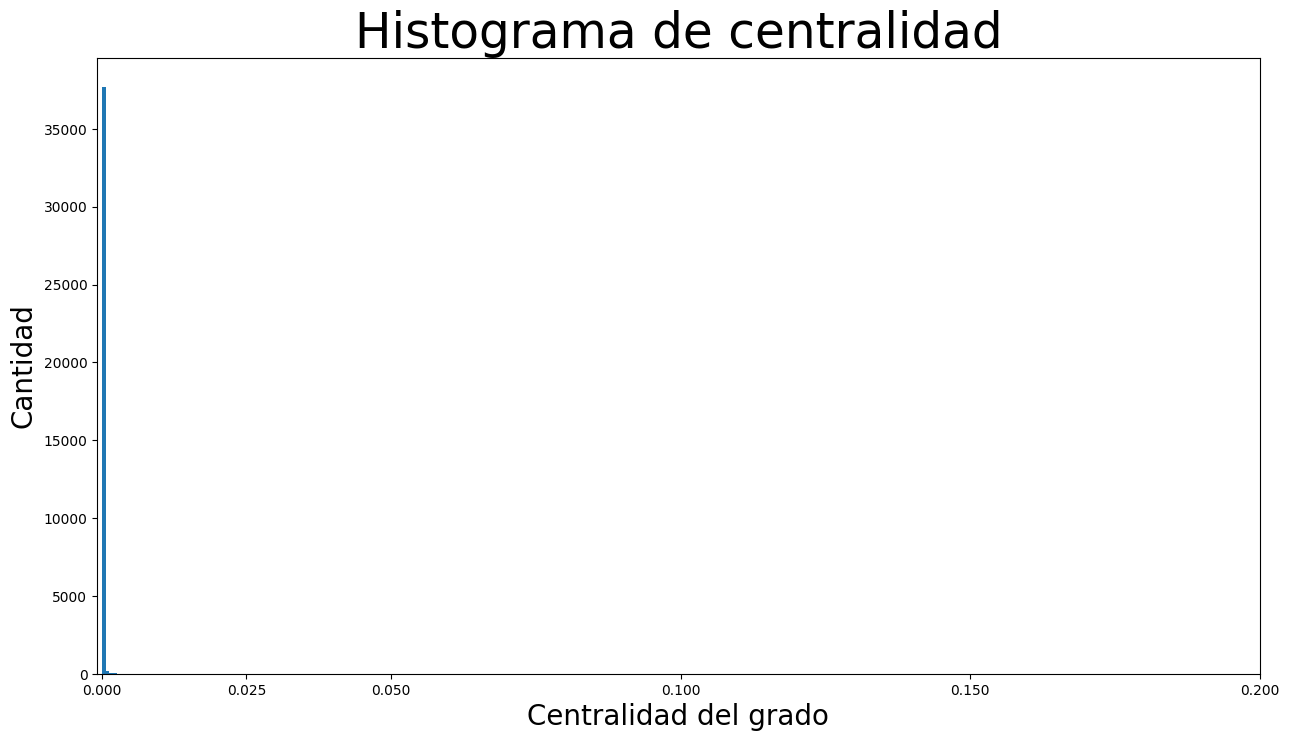

In [6]:
plt.figure(figsize=(15, 8))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])
plt.title("Histograma de centralidad", fontdict={"size": 35}, loc="center")
plt.xlabel("Centralidad del grado", fontdict={"size": 20})
plt.ylabel("Cantidad", fontdict={"size": 20})
plt.show()

In [7]:
# Dividir los datos en entrenamiento, validación y prueba
transform = RandomLinkSplit(is_undirected=True, num_val=0.1, num_test=0.1)
train_data, val_data, test_data = transform(data)

In [36]:
# Obtener información del dataset
print(f'Dataset: Amazon Food Reviews')
print('----------------------------')
print(f'Numero de grafos: 1')
print(f'Cantidad de Nodos: {data.x.shape[0]}')
print(f'Cantidad de features: {data.x.shape[1]}')
print(f'Cantidad de clases: N/A')  # Si no hay clases específicas en el dataset

# Obtener información del grafo
print(f'\nGraph:')
print('------')
print(f'Se tienen links dirigidos: {data.is_directed()}')
print(f'Grafo tiene nodos aislados: {data.has_isolated_nodes()}')
print(f'Grafo tiene self-loops: {data.has_self_loops()}')

# Obtener los grados de los nodos
degrees = degree(data.edge_index[0], data.num_nodes)
isolated_nodes = (degrees == 0).sum().item()
nodes_with_degree_1 = (degrees == 1).sum().item()

print(f'Cantidad de nodos aislados: {isolated_nodes}')
print(f'Cantidad de nodos con grado = 1: {nodes_with_degree_1}')

Dataset: Amazon Food Reviews
----------------------------
Numero de grafos: 1
Cantidad de Nodos: 37948
Cantidad de features: 745
Cantidad de clases: N/A

Graph:
------
Se tienen links dirigidos: False
Grafo tiene nodos aislados: False
Grafo tiene self-loops: False
Cantidad de nodos aislados: 0
Cantidad de nodos con grado = 1: 30653


# Modelo GCN - Graph Convolutional Network

In [8]:
class SimpleGraphAutoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SimpleGraphAutoencoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, data):
        x = self.conv1(data.x, data.edge_index, edge_weight=data.edge_weight)
        x = x.relu()
        return self.conv2(x, data.edge_index, edge_weight=data.edge_weight)

    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)
        return logits

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()



In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleGraphAutoencoder(in_channels=num_node_features, hidden_channels=128, out_channels=64).to(device)
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)
optimizer = Adam(model.parameters(), lr=0.01)

def get_link_labels(pos_edge_index, neg_edge_index):
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

def train(data):
    model.train()
    neg_edge_index = negative_sampling(edge_index=data.edge_index, num_nodes=data.num_nodes, num_neg_samples=data.edge_index.size(1)//2)
    optimizer.zero_grad()
    z = model.encode(data)
    link_logits = model.decode(z, data.edge_index, neg_edge_index)
    link_labels = get_link_labels(data.edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(data):
    model.eval()
    pos_edge_index = data.edge_index
    neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=data.num_nodes, num_neg_samples=pos_edge_index.size(1)//2)
    z = model.encode(data)
    link_logits = model.decode(z, pos_edge_index, neg_edge_index)
    link_probs = link_logits.sigmoid()
    link_labels = get_link_labels(pos_edge_index, neg_edge_index)
    pred_labels = (link_probs > 0.5).float()
    accuracy = (pred_labels == link_labels).sum().item() / link_labels.size(0)
    return accuracy

best_val_perf = test_perf = 0
for epoch in range(1, 101):
    train_loss = train(train_data)
    val_perf = test(val_data)
    tmp_test_perf = test(test_data)
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Val: {best_val_perf:.4f}, Test: {test_perf:.4f}')

z = model.encode(train_data)
predict_edge_index = model.decode_all(z)
predict_edge_index = pd.DataFrame(predict_edge_index.cpu().numpy().T, columns=['start_node', 'end_node'])
print(predict_edge_index.head())


C:\Users\adria\anaconda3\envs\mi_entorno_virtual\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch: 010, Loss: 0.9946, Val: 0.7666, Test: 0.7651
Epoch: 020, Loss: 0.5580, Val: 0.8009, Test: 0.8003
Epoch: 030, Loss: 0.4007, Val: 0.8253, Test: 0.8252
Epoch: 040, Loss: 0.3579, Val: 0.8319, Test: 0.8295
Epoch: 050, Loss: 0.3372, Val: 0.8397, Test: 0.8336
Epoch: 060, Loss: 0.3255, Val: 0.8397, Test: 0.8336
Epoch: 070, Loss: 0.3135, Val: 0.8397, Test: 0.8336
Epoch: 080, Loss: 0.3104, Val: 0.8397, Test: 0.8336
Epoch: 090, Loss: 0.3062, Val: 0.8397, Test: 0.8336
Epoch: 100, Loss: 0.3046, Val: 0.8397, Test: 0.8336
   start_node  end_node
0           0         0
1           0         1
2           0         2
3           0         3
4           0         4


###  modelo GraphSAGE

In [22]:
# Crear los índices de aristas positivas para entrenamiento, validación y prueba
train_data.train_pos_edge_index = train_data.edge_index
val_data.val_pos_edge_index = val_data.edge_label_index[:, val_data.edge_label == 1]
test_data.test_pos_edge_index = test_data.edge_label_index[:, test_data.edge_label == 1]

# Definir el modelo GraphSAGE
class LinkPrediction(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(LinkPrediction, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

def negative_sampling(edge_index, num_nodes=None, num_neg_samples=None):
    """Muestrea aristas negativas aleatorias."""
    num_nodes = edge_index.max().item() + 1 if num_nodes is None else num_nodes
    num_neg_samples = edge_index.size(1) if num_neg_samples is None else num_neg_samples

    adj_mask = torch.zeros(num_nodes, num_nodes, dtype=torch.bool)
    adj_mask[edge_index[0], edge_index[1]] = 1

    edges = torch.randint(0, num_nodes, size=(2, num_neg_samples), dtype=torch.long)
    mask = adj_mask[edges[0], edges[1]]
    while mask.sum().item() != 0:
        replacements = torch.randint(0, num_nodes, size=(2, mask.sum().item()), dtype=torch.long)
        edges[:, mask] = replacements
        mask = adj_mask[edges[0], edges[1]]
    return edges

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

model = LinkPrediction(train_data.x.size(1), 128, 64).to(device)
optimizer = Adam(model.parameters(), lr=0.005)

def train(data):
    model.train()
    optimizer.zero_grad()
    z = model(data.x, data.train_pos_edge_index)

    pos_logits = (z[data.train_pos_edge_index[0]] * z[data.train_pos_edge_index[1]]).sum(dim=1)
    neg_edge_index = negative_sampling(data.train_pos_edge_index, data.num_nodes, data.train_pos_edge_index.size(1))
    neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)

    logits = torch.cat([pos_logits, neg_logits])
    labels = torch.cat([torch.ones(pos_logits.size(0)), torch.zeros(neg_logits.size(0))]).to(device)

    loss = F.binary_cross_entropy_with_logits(logits, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model(data.x, data.edge_index)

    pos_logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
    neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)

    logits = torch.cat([pos_logits, neg_logits])
    labels = torch.cat([torch.ones(pos_logits.size(0)), torch.zeros(neg_logits.size(0))]).to(device)

    predictions = (logits > 0).float()
    correct = predictions.eq(labels).sum().item()
    total = len(labels)
    return correct / total

train_neg_edge_index = negative_sampling(train_data.train_pos_edge_index, train_data.x.size(0))

for epoch in range(100):
    train_loss = train(train_data)
    print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}")

val_neg_edge_index = negative_sampling(val_data.val_pos_edge_index, val_data.x.size(0))
test_neg_edge_index = negative_sampling(test_data.test_pos_edge_index, test_data.x.size(0))

val_accuracy = evaluate(model, val_data, val_data.val_pos_edge_index, val_neg_edge_index)
test_accuracy = evaluate(model, test_data, test_data.test_pos_edge_index, test_neg_edge_index)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1, Loss: 1.0807
Epoch 2, Loss: 0.6792
Epoch 3, Loss: 0.6940
Epoch 4, Loss: 0.6519
Epoch 5, Loss: 0.6175
Epoch 6, Loss: 0.6086
Epoch 7, Loss: 0.5516
Epoch 8, Loss: 0.5325
Epoch 9, Loss: 0.5391
Epoch 10, Loss: 0.5156
Epoch 11, Loss: 0.5117
Epoch 12, Loss: 0.4881
Epoch 13, Loss: 0.4767
Epoch 14, Loss: 0.4752
Epoch 15, Loss: 0.4708
Epoch 16, Loss: 0.4615
Epoch 17, Loss: 0.4543
Epoch 18, Loss: 0.4563
Epoch 19, Loss: 0.4453
Epoch 20, Loss: 0.4348
Epoch 21, Loss: 0.4377
Epoch 22, Loss: 0.4318
Epoch 23, Loss: 0.4338
Epoch 24, Loss: 0.4268
Epoch 25, Loss: 0.4315
Epoch 26, Loss: 0.4191
Epoch 27, Loss: 0.4161
Epoch 28, Loss: 0.4190
Epoch 29, Loss: 0.4088
Epoch 30, Loss: 0.4136
Epoch 31, Loss: 0.4086
Epoch 32, Loss: 0.4057
Epoch 33, Loss: 0.4028
Epoch 34, Loss: 0.4021
Epoch 35, Loss: 0.3956
Epoch 36, Loss: 0.4018
Epoch 37, Loss: 0.3970
Epoch 38, Loss: 0.3978
Epoch 39, Loss: 0.3988
Epoch 40, Loss: 0.3945
Epoch 41, Loss: 0.3902
Epoch 42, Loss: 0.3921
Epoch 43, Loss: 0.3903
Epoch 44, Loss: 0.38